In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [2]:
# correct params
N = 1e6 
M = 2 

beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
fsa   = 1         # the self-isolation parameter (assumed to be known)
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

def contactMatrix(t):
    return C 

Tf = 300
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

S0 = Ni
Ia0 = np.zeros((M))
Ia0[1] += 2
S0[1] -= 2

Is0 = np.zeros((M))
E0 = np.zeros((M))

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau_leaping')

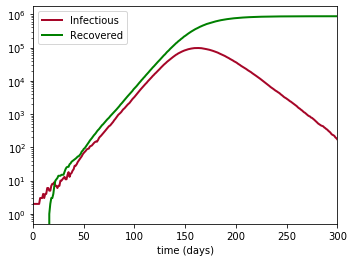

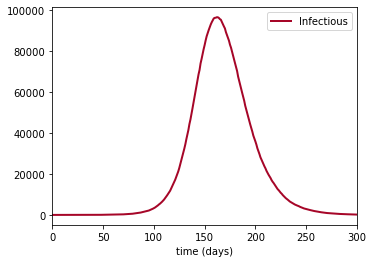

In [3]:
## Plot Results ##

Infectious = np.sum((sto_model.Is(data) + sto_model.Ia(data)), axis=1) 
R = np.sum(sto_model.R(data), axis=1)

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.semilogy(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.semilogy(data['t'], R,              color = 'green',   label = 'Recovered'  ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2)
plt.legend()
plt.show()

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2) 
plt.legend()
plt.show()

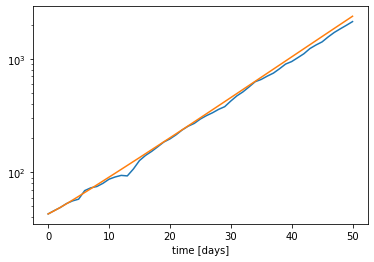

In [4]:
# load the data and rescale to intensive variables 
N_start = 50
Tf_inference = 50 
Nf_inference = Tf_inference + 1

A = 1

x = data['X'].astype('float')
x = x[N_start:N_start+Nf_inference]/A
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, Ni/A, A, steps)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
det_model = estimator.make_det_model(parameters)


time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference, det_model, contactMatrix)

plt.semilogy(np.sum(obs[:, -M:], axis=1))
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm)[:, -M:], axis=1))
plt.xlabel("time [days]")
plt.show()

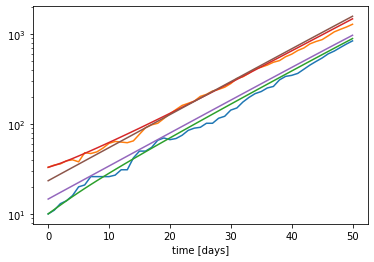

In [5]:
# test the approximation of the initial conditions by v 
zero_state = np.zeros((4*M))
zero_state[:M] = Ni 
dev = x0 - zero_state 
c = np.linalg.norm(dev, ord=1)
v = estimator.lin_mode_inits(c, contactMatrix)


xm_approx = estimator.integrate(v, 0, Tf_inference, Nf_inference, det_model, contactMatrix)

plt.semilogy(obs[:, -2:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm)[:, -2:])
plt.semilogy(np.einsum('ij,kj->ki', fltr, xm_approx)[:, -2:])
plt.xlabel("time [days]")
plt.show()

In [6]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa,'gIs':gIs, 'gE':gE, 'fsa':fsa}

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, v, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

686.5213698541339
0.049634695053100586


In [7]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3

beta_g = 0.03
beta_std = 0.02
beta_bounds = (eps, 1)

gIa_g = 0.15
gIa_std = 0.02 
gIa_bounds = (eps, 1)

gIs_g = 0.15
gIs_std = 0.05
gIs_bounds = (eps, 1) 

gE_g = 0.11
gE_std = 0.05 
gE_bounds = (eps, 0.2) 

coeff_g = c
coeff_std = coeff_g*2 
coeff_b = (eps, coeff_g*100)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
bounds = np.array([beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, 
                   coeff_b])
guess = np.array([beta_g, gIa_g, gIs_g, gE_g, coeff_g])
stds = np.array([beta_std, gIa_std, gIs_std, gE_std, coeff_std])
param_keys = ['beta', 'gIa', 'gIs', 'gE']
start_time = time.time()
estimator.set_lyapunov_method('euler')
params = estimator.latent_infer_parameters_lin_mode_init(param_keys, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    tangent=True,
                                    enable_global=True, 
                                    cma_population=32,
                                    global_max_iter=100, global_atol=10, 
                                    local_max_iter=200,
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)
print(params)

Starting global minimisation...
(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 5 (seed=1376188073, Fri Jun 19 14:28:56 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     32 1.169816322148389e+03 1.0e+00 9.72e-01  2e-02  9e+02 0:00.5
    2     64 1.073688677221723e+03 1.4e+00 9.47e-01  1e-02  9e+02 0:01.0
    3     96 7.885247068643599e+02 1.8e+00 7.81e-01  1e-02  7e+02 0:01.4
    8    256 7.077039570061318e+02 3.2e+00 6.77e-01  6e-03  5e+02 0:04.7
   17    544 6.887087575858696e+02 7.3e+00 5.15e-01  6e-03  2e+02 0:08.8
   27    864 6.787505819617812e+02 1.9e+01 3.05e-01  2e-03  5e+01 0:13.4
Optimal value (global minimisation):  678.7505819617812
Starting local minimisation...
Optimal value (local minimisation):  677.3420968104922
14.776029109954834
[2.42208329e-02 1.63437933e-01 1.39081526e-01 7.17049874e-02
 5.51110090e+02]


In [10]:
# save the parameters 
np.save('SEIR_latent_param_M=2.npy', params)

In [11]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE,'fsa':fsa}
x0 = x[0]
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
print(parameters, logp)

print('\nTrue initial conditions: ') 
print((x0*A).astype('int'))
print('R initial = ', (Ni - A*np.sum(x0.reshape((4, M)), axis=0)))

params = np.load('SEIR_latent_param_M=2.npy')
best_estimates = estimator.fill_params_dict(param_keys, params)

coeff = params[-1]
print('\ncoeff for init', coeff)

estimator.set_params(best_estimates)
x0_inf = estimator.lin_mode_inits(coeff, contactMatrix)
logp = estimator.minus_logp_red(best_estimates, x0_inf, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)

print('\nBest estimates')
print(best_estimates, logp)


print('\nInferred initial conditons: ') 
print((x0_inf*A).astype('int'))
print('R initial = ', (Ni - A*np.sum(x0_inf.reshape((4, M)), axis=0)))

True parameters
{'alpha': array([0.5, 0.2]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 1} 647.3096589497056

True initial conditions: 
[249884 749828     51     77     14     11     10     33]
R initial =  [41. 49.]

coeff for init 551.1100898555884

Best estimates
{'alpha': array([0.5, 0.2]), 'beta': 0.024220832855903714, 'gIa': 0.1634379327129222, 'gIs': 0.13908152607718458, 'gE': 0.07170498744114376, 'fsa': array([1., 1.])} 679.616591316597

Inferred initial conditons: 
[249840 749834     86     88     12      5     13     22]
R initial =  [46.83406035 47.09900991]


In [17]:
# Calculate hessian 
eps = 1e-2*params
print(eps)
hess = estimator.hessian_lin_mode(param_keys, params, guess, stds,
                                    obs, fltr, Tf_inference, Nf_inference, contactMatrix, 
                                    tangent=True,
                                    infer_scale_parameter=False,
                                    eps=eps, fd_method='central')

[2.42208329e-04 1.63437933e-03 1.39081526e-03 7.17049874e-04
 5.51110090e+00]


In [22]:
print(hess)
# np.linalg.cholesky(hess)
vals, vecs = np.linalg.eig(hess)
print(vals)

[[ 1.46032512e+07 -5.24715539e+05 -5.23198923e+05  2.13443325e+06
  -9.99135619e+01]
 [-5.24715539e+05  2.55007538e+04  3.71930363e+04 -4.98188311e+04
   9.21163326e+00]
 [-5.23198923e+05  3.71930363e+04  1.50656247e+05 -1.36696557e+04
   1.64152001e+01]
 [ 2.13443325e+06 -4.98188311e+04 -1.36696557e+04  5.49704696e+05
   3.41896245e+01]
 [-9.99135619e+01  9.21163326e+00  1.64152001e+01  3.41896245e+01
   1.07932260e-02]]
[1.49571502e+07 2.67499837e+05 1.02007740e+05 2.45511569e+03
 9.01878459e-05]


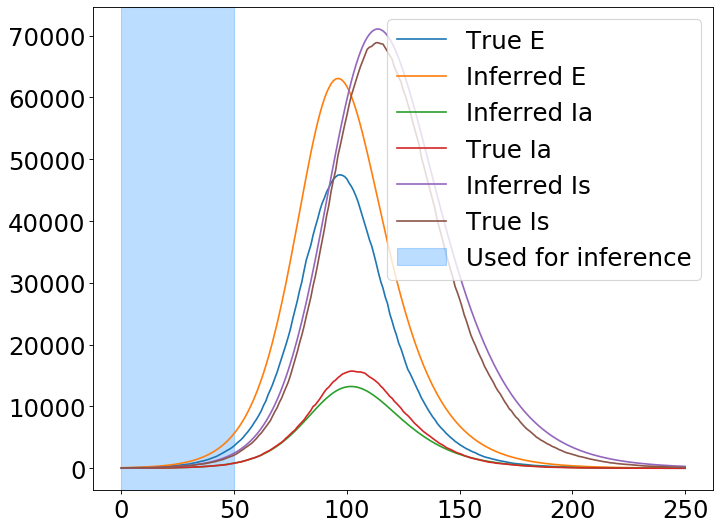

In [20]:
# plot the guessed trajectory and the true trajectory
estimator.set_params(best_estimates)
det_model = estimator.make_det_model(best_estimates)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(x0_inf, 0, Tf-N_start, Nf-N_start, det_model, contactMatrix)
x = data['X'][N_start:]/A
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,M], label='True E')
plt.plot(x_det[:, M], label='Inferred E')
plt.plot(x_det[:, 2*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Ia')
plt.plot(np.sum(x_det[:, 3*M:], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show()